Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)

https://github.com/1iyiwei/pyml

[MIT License](https://github.com/1iyiwei/pyml/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning

Deciphering the black magic

How to
* train a model
* evaluate a model
* fine tune (and debug) a model 

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,sklearn

last updated: 2016-09-07 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
sklearn 0.17.1


*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Streamlining workflows with pipelines](#Streamlining-workflows-with-pipelines)
  - [Loading the Breast Cancer Wisconsin dataset](#Loading-the-Breast-Cancer-Wisconsin-dataset)
  - [Combining transformers and estimators in a pipeline](#Combining-transformers-and-estimators-in-a-pipeline)
- [Using k-fold cross-validation to assess model performance](#Using-k-fold-cross-validation-to-assess-model-performance)
  - [The holdout method](#The-holdout-method)
  - [K-fold cross-validation](#K-fold-cross-validation)
- [Debugging algorithms with learning and validation curves](#Debugging-algorithms-with-learning-and-validation-curves)
  - [Diagnosing bias and variance problems with learning curves](#Diagnosing-bias-and-variance-problems-with-learning-curves)
  - [Addressing overfitting and underfitting with validation curves](#Addressing-overfitting-and-underfitting-with-validation-curves)
- [Fine-tuning machine learning models via grid search](#Fine-tuning-machine-learning-models-via-grid-search)
  - [Tuning hyperparameters via grid search](#Tuning-hyperparameters-via-grid-search)
  - [Algorithm selection with nested cross-validation](#Algorithm-selection-with-nested-cross-validation)
- [Looking at different performance evaluation metrics](#Looking-at-different-performance-evaluation-metrics)
  - [Reading a confusion matrix](#Reading-a-confusion-matrix)
  - [Optimizing the precision and recall of a classification model](#Optimizing-the-precision-and-recall-of-a-classification-model)
  - [Plotting a receiver operating characteristic](#Plotting-a-receiver-operating-characteristic)
  - [The scoring metrics for multiclass classification](#The-scoring-metrics-for-multiclass-classification)
- [Summary](#Summary)

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

# Streamlining workflows with pipelines

Fit transformers (e.g. standardization) and predictors (e.g. SVM) into a single pipeline for easy manipulation.

## Loading the Breast Cancer Wisconsin dataset

Malignant versus benign tumor cells based on 31 features (large enough for experiments in this chapter)

In [4]:
import pandas as pd

#wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [5]:
df.shape

(569, 32)

<hr>

### Note:


If the link to the Breast Cancer Wisconsin dataset dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/wdbc/wdbc.data](./../datasets/wdbc/wdbc.data).

Or you could fetch it via

In [6]:
wdbc_another_source = 'https://raw.githubusercontent.com/1iyiwei/pyml/master/code/datasets/wdbc/wdbc.data'
df = pd.read_csv(wdbc_another_source, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [8]:
import numpy as np
np.bincount(y)

array([357, 212], dtype=int64)

In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

## Combining transformers and estimators in a pipeline

We can chain together multiple ML components into a single entity called "pipeline" for easy manipulation.

This is also a common practice for building neural networks in deep learning libraries (e.g. TensorFlow and Torch7).

<img src='./images/06_01.png' width=80%>

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# construct a pipeline consisting of different components
# each entry contains an identifier, and the corresponding component
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

# now a single fit or predict call will go through all components
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


# Using k-fold cross validation to assess model performance

Need to partition available data into 3 main categories:
* Training: fit model parameters
* Test: evaluate model performance
* Validation: select model hyper-parameters

Need to separate them to avoid over-fit

Data is often limited, so need smart partition

Different ways for partition

## The holdout method

Test set
* only used for evaluation in the end (to make sure the model really generalizes)

Training & validation sets
* if we have only one model and one set of hyper-parameters, we can just train
* for multiple models or sets of hyper-parameters, we use a separate validation set
* train each model/hyper-parameter-set $\rightarrow$ validate $\rightarrow$ pick best

<img src='./images/06_02.png' width=80%> 

Disadvantage of such fixed partition
* model performance can be sensitive to the particular choice

## K-fold cross-validation

Vary the data partition to reduce variance for model training

Often applied for training-validation data partition (with separate test data)

But the principle can be applied in various ways, e.g. for test data

The "test fold" below is for validation....
<img src='./images/06_03.png' width=80%> 

The iterations should be independent to avoid cumulative learning
* fit() versus partial_fit()

How to choose k?
* large k for small data sets to ensure sufficient training data

Straitified k fold
* preserves class proportions within each fold instead of purely random (notice the code below)
* helps reduce variance in data and thus the trained model

In [11]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

# compute the data indices for each fold
kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=1)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


In [12]:
# even simpler code...
# allows parallel execution via n_jobs
# same result as above
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


# Debugging algorithms with learning and validation curves

Two simple and useful diagnostic tools for model training and performance 

## Diagnosing bias and variance problems with learning curves

<img src='./images/06_04.png' width=70% align=right>

Learning curve
* plots performance against data size

Goal
* low bias
* low variance

Observations: when training size $\uparrow$ 
* training performance $\downarrow$
* validation performance $\uparrow$

High bias
* model too simple (with respect to the data)
* increase model complexity
* decrease regularization

High variance
* model too complex
* dimensionality reduction
* decrease model complexity
* increase regularization

### Plot learning curves via scikit-learn

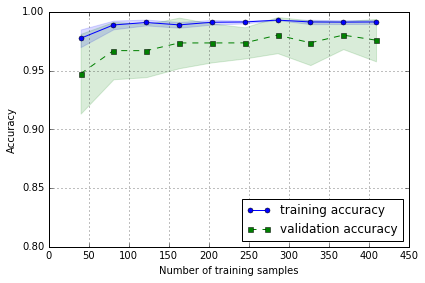

In [13]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10), # 10 intervals
                               cv=10, # k = 10 for cross validation
                               n_jobs=1)

# the returned scores are stacked in columns (n_ticks, num_folds)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

## Addressing over- and underfitting with validation curves

Validation curves are similar to learning curves, but plot against parameters instead of training size.

The sklearn API allows selection of parameter and range.


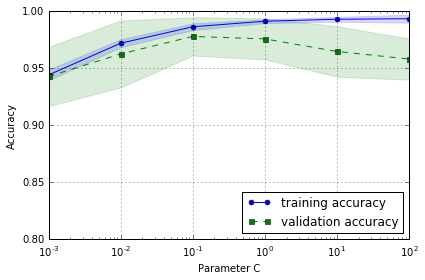

In [14]:
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

#print('all parameters: %s' % pipe_lr.get_params())

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

Which $C$ value should we pick from the experiment above?

Hint: the goal includes:
* low bias, i.e. high accuracy
* low variance, i.e. similar training and test/validation accuracy

# Fine-tuning machine learning models via search

Manually selecting hyper-parameters can be tedious

Automatic search through a set of hyper-parameters, and find the best one
* write your own code (e.g. loops)
* grid and random search in scikit-learn


## Tuning hyperparameters via grid search 

Given a set of parameters $p_i$ each with $N_i$ different values, search through all combinations $\prod_i N_i$.

Each such set is like a grid.


In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# can specify multiple grids, e.g. 2 below
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [16]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


## Tuning hyperparameters via randomized search

Grid search can suffer from curse of dimensionality

Random sampling with a per-defined budget (number of samples) can help

In [17]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_range = uniform(scale=1000)
 
param_distributions = {'clf__C': param_range,
                       'clf__kernel': ['linear', 'rbf'],
                       'clf__gamma': param_range}

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_distributions,
                        scoring='accuracy',
                        n_iter=100,
                        cv=10,
                        n_jobs=1)

rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

clf = rs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

0.967032967033
{'clf__C': 5.762359336631162, 'clf__kernel': 'linear', 'clf__gamma': 730.8086308119889}
Test accuracy: 0.965


## Algorithm selection with nested cross-validation

Partition data into training, validation, and test sets in nested hierarchy

<img src='./images/06_07.png' width=80%>

In [18]:
# cross validation for outer loop
# grid search for inner loop
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

# Note: Optionally, you could use cv=2 
# in the GridSearchCV above to produce
# the 5 x 2 nested CV that is shown in the figure.

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [19]:
# compare decision tre with SVM above
# and see whose performance is better
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


# Looking at different performance evaluation metrics

<a href="https://en.wikipedia.org/wiki/Precision_and_recall"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/320px-Precisionrecall.svg.png" align=right></a>

<b>T</b>rue
<br>
<b>F</b>alse
<br>
<b>P</b>ositive
<br>
<b>N</b>egative

ACC (accuracy) = $\frac{TP+TN}{TP+TN+FP+FN}$
<br>
ERR (error) = 1 - ACC

TPR (true positive rate) = $\frac{TP}{TP+FN}$
<br>
FPR (false positive rate) = $\frac{FP}{FP+TN}$

PRE (precision) = $\frac{TP}{TP+FP}$
<br>
REC (recall) = TPR

F1 = $2\frac{PRE \times REC}{PRE + REC}$


## Reading a confusion matrix

<img src='./images/06_08.png' width=40%>

In [20]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


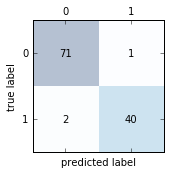

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

### Additional Note

Remember that we previously encoded the class labels so that *malignant* samples are the "postive" class (1), and *benign* samples are the "negative" class (0):

In [22]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [23]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Next, we printed the confusion matrix like so:

In [24]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Note that the (true) class 0 samples that are correctly predicted as class 0 (true negatives) are now in the upper left corner of the matrix (index 0, 0). In order to change the ordering so that the true negatives are in the lower right corner (index 1,1) and the true positves are in the upper left, we can use the `labels` argument like shown below:

In [25]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


We conclude:

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the samples that belong to class 0 (true negatives) and 40 samples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 sample from class 0 as class 1 (false positive), and it predicted that 2 samples are benign although it is a malignant tumor (false negatives).

## Optimizing the precision and recall of a classification model

Previously we have been using accuracy as the score for optimization
* e.g. grid search

We can easily plug in other performance metrics.

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [27]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.982798668208
{'clf__C': 0.1, 'clf__kernel': 'linear'}


## Plotting a receiver operating characteristic

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Plot TPR versus FPR of a model by varing one of its parameters.
* decision threshold in roc_curve(), see below

In [28]:
# modified from http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
import numpy as np
from sklearn.metrics import roc_curve

y_truth = np.array([0, 0, 1, 1])

#y_score = np.array([0, 0, 1, 1]) # completely right
y_score = np.array([0.1, 0.4, 0.35, 0.8]) # partially right
#y_score = np.array([1, 1, 0, 0]) # completely wrong

fpr, tpr, thresholds = roc_curve(y_truth, y_score, pos_label=1)

print(fpr)
print(tpr)
print(thresholds)

[ 0.   0.5  0.5  1. ]
[ 0.5  0.5  1.   1. ]
[ 0.8   0.4   0.35  0.1 ]


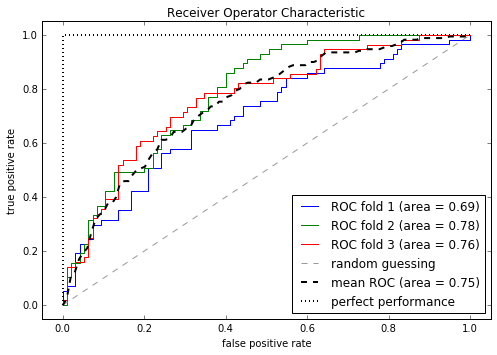

In [29]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

# intentionally use only 2 features to make the task harder and the curves more interesting
X_train2 = X_train[:, [4, 14]]
X_test2 = X_test[:, [4, 14]]

cv = StratifiedKFold(y_train, n_folds=3, random_state=1)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    #mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [30]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test2)

In [31]:
# area under curve (AUC) can give us more information than accuracy
# which is a single cut-off point (e.g. 0.5 for probabilities) of ROC
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


Can plot other types of curves such as precision-recall curve
* exercise

## The scoring metrics for multiclass classification

Performance metrics above are defined for binary classification

Extension for multi-class classification (one versus rest):
* micro
* macro

For $K$ classes, PRE (precision) can be computed as follows:

$$
PRE_{micro} = \frac{\sum_{i=1}^K TP_i}{\sum_{i=1}^K TP_i + \sum_{i=1}^K FP_i}
$$

$$
PRE_{macro} = \frac{\sum_{i=1}^K PRE_i}{K}
$$

Ditto other metrics (e.g. recall, accuracy, F1)

Micro
* weigh each sample equally

Macro
* weigh each class equally
* can specify weights in API

In [32]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

# Summary

* Pipeline to chain transformer and classifier together
* Cross validation: varioius ways to split training, validation, test datasets
* Search hyper-parameters: grid, random
* Performance metrics: accuracy, precision, recall, etc.

# Reading

* PML Chapter 6
